<a href="https://colab.research.google.com/github/joannamwalsh/GLMFinalProject/blob/main/FinalProjectGLMCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages(c("tensorflow","keras"))
install.packages("caret")
install.packages("varhandle")

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘reticulate’, ‘tfruns’, ‘tfautograph’, ‘zeallot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(keras)
library(tidyverse)
library(caret)
library(pROC)
library(varhandle)

In [ ]:
imagedata <- read.csv("/content/imagedata.csv")
names(imagedata) <- c(paste("pixel.", seq(1, (ncol(imagedata) - 1), 1)), "DX")
imagedata <- imagedata %>% mutate(DX = case_when(DX == "Non Demented" ~ 1, 
                                            DX == "Very Mild Demented" ~ 2, 
                                            DX == "Mild Demented" ~ 3, 
                                            DX == "Moderate Demented" ~ 4))
                                    

In [ ]:
imagedata$DX <- as.factor(imagedata$DX)

In [ ]:
set.seed(1)
sequence = seq(1, 6400, 1)
folds <- list()
for (i in 1:10) {
folds[[i]] <- sample(size = 640, x = sequence, replace = FALSE)
sequence = sequence[!(sequence %in% folds[[i]])]
}



In [ ]:
set.seed(1)
loss <- c()
accuracy <- c()
mcroc <- c()
actltpred <- c()
actgtpred <- c()
nonacc <- c()
verymildacc <- c()
mildacc <- c()
modacc <- c()
dementiaacc <- c()

for (i in 1:10) {
  train <- imagedata[-folds[[i]], ]
  test <- imagedata[folds[[i]], ]
  y <- train$DX
  y_mat <- to_categorical(y)[, 2:5]
  X <- as.matrix(train[, -ncol(train)])
  train_means <- apply(X, 2, mean)
  train_sd <- sd(as.vector(X))
  X <- sweep(X, 2L, train_means)/train_sd

  y_test <- test$DX
  y_mat_test <- to_categorical(y_test)[, 2:5]
  X_test <- as.matrix(test[, -ncol(test)])
  X_test <- sweep(X_test, 2L, train_means)/train_sd

  X <- array_reshape(X,c(nrow(X),43,43, 1))
  X_test <- array_reshape(X_test,c(nrow(X_test),43,43, 1))
  model <- keras_model_sequential()  %>% # Start with hidden 2D convolutional layer being fed 43x43 pixel images
  layer_conv_2d(filters = 43, kernel_size = c(3,3), input_shape = c(43, 43, 1), activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2,2)) %>% 
  layer_conv_2d(filters = 86, kernel_size = c(3,3),activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2,2)) %>%
  layer_conv_2d(filters = 172, kernel_size = c(3,3),activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2,2)) %>%
  layer_flatten() %>%
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = 344, activation = "relu") %>%
  layer_dense(units = 4, activation = "softmax")

  model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = "adam",
  metrics= "accuracy")
  
  history <- model %>% fit(x = X, y = y_mat, epochs = 20, validation_data = list(X_test, y_mat_test))
  loss <- c(loss, evaluate(model, X_test, y_mat_test)[1])
  accuracy <- c(accuracy, evaluate(model, X_test, y_mat_test)[2])

  predictions <- predict(model, X_test)
  colnames(predictions) <- c("1", "2", "3", "4")
  mcroc <- c(mcroc, multiclass.roc(test$DX, predictions)$auc)
  predclasses <- as.vector(predict(model, X_test) %>% k_argmax()) + 1

  test$DXunf <- unfactor(test$DX)
  actltpred <- c(actltpred, sum(test$DXunf < predclasses)/length(predclasses))
  actgtpred <- c(actgtpred, sum(test$DXunf > predclasses)/length(predclasses))
  nonacc <- c(nonacc, sum(test$DXunf == 1 & predclasses == 1)/sum(test$DXunf == 1))
  verymildacc <- c(verymildacc, sum(test$DXunf == 2 & predclasses == 2)/sum(test$DXunf == 2))
  mildacc <- c(mildacc, sum(test$DXunf == 3 & predclasses == 3)/sum(test$DXunf == 3))
  modacc <- c(modacc, sum(test$DXunf == 4 & predclasses == 4)/sum(test$DXunf == 4))
  dementiaacc <- c(dementiaacc, sum(test$DXunf != 1 & predclasses != 1)/sum(test$DXunf != 1))
}

In [ ]:
results <- as.data.frame(cbind(unname(loss), unname(accuracy), mcroc, actltpred, actgtpred, nonacc, verymildacc, mildacc, modacc, dementiaacc))
names(results) <- c("loss", "accuracy", "mcroc", "actltpred", "actgtpred", "nonacc", "verymildacc", "mildacc", "modacc", "dementiaacc")
write.csv(results, file = "results.csv")

In [ ]:
head(results)

,loss,accuracy,mcroc,actltpred,actgtpred,nonacc,verymildacc,mildacc,modacc,dementiaacc
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.06128575,0.9781250,0.9991178,0.0093750,0.0125000,0.9771987,0.9737991,0.9894737,1.0000000,0.9737991
2,0.08360074,0.9718750,0.9978724,0.0187500,0.0093750,0.9933775,0.9601594,0.9285714,1.0000000,0.9601594
3,0.07142700,0.9796875,0.9967566,0.0046875,0.0156250,0.9828571,0.9716981,0.9857143,1.0000000,0.9716981
4,0.08993264,0.9734375,0.9969590,0.0109375,0.0156250,0.9757576,0.9672897,0.9777778,1.0000000,0.9672897
5,0.08964975,0.9671875,0.9987392,0.0062500,0.0265625,0.9670659,0.9626168,0.9883721,0.8333333,0.9626168
6,0.06698625,0.9781250,0.9980341,0.0046875,0.0171875,0.9713376,0.9822222,0.9893617,1.0000000,0.9822222


In [ ]:
set.seed(1)
i <- 1
  train <- imagedata[-folds[[i]], ]
  test <- imagedata[folds[[i]], ]
  y <- train$DX
  y_mat <- to_categorical(y)[, 2:5]
  X <- as.matrix(train[, -ncol(train)])
  train_means <- apply(X, 2, mean)
  train_sd <- sd(as.vector(X))
  X <- sweep(X, 2L, train_means)/train_sd

  y_test <- test$DX
  y_mat_test <- to_categorical(y_test)[, 2:5]
  X_test <- as.matrix(test[, -ncol(test)])
  X_test <- sweep(X_test, 2L, train_means)/train_sd

  X <- array_reshape(X,c(nrow(X),43,43, 1))
  X_test <- array_reshape(X_test,c(nrow(X_test),43,43, 1))
  model <- keras_model_sequential()  %>% # Start with hidden 2D convolutional layer being fed 43x43 pixel images
  layer_conv_2d(filters = 43, kernel_size = c(3,3), input_shape = c(43, 43, 1), activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2,2)) %>% 
  layer_conv_2d(filters = 86, kernel_size = c(3,3),activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2,2)) %>%
  layer_conv_2d(filters = 172, kernel_size = c(3,3),activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2,2)) %>%
  layer_flatten() %>%
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = 344, activation = "relu") %>%
  layer_dense(units = 4, activation = "softmax")

  model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = "adam",
  metrics= "accuracy")
  summary(model)

  history <- model %>% fit(x = X, y = y_mat, epochs = 20, validation_data = list(X_test, y_mat_test))
 
  

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_2 (Conv2D)                  (None, 41, 41, 43)              430         
 max_pooling2d_2 (MaxPooling2D)     (None, 20, 20, 43)              0           
 conv2d_1 (Conv2D)                  (None, 18, 18, 86)              33368       
 max_pooling2d_1 (MaxPooling2D)     (None, 9, 9, 86)                0           
 conv2d (Conv2D)                    (None, 7, 7, 172)               133300      
 max_pooling2d (MaxPooling2D)       (None, 3, 3, 172)               0           
 flatten (Flatten)                  (None, 1548)                    0           
 dropout (Dropout)                  (None, 1548)                    0           
 dense_1 (Dense)                    (None, 344)                     532856      
 dense (Dense)                      (None, 4)                       1380        
Total pa

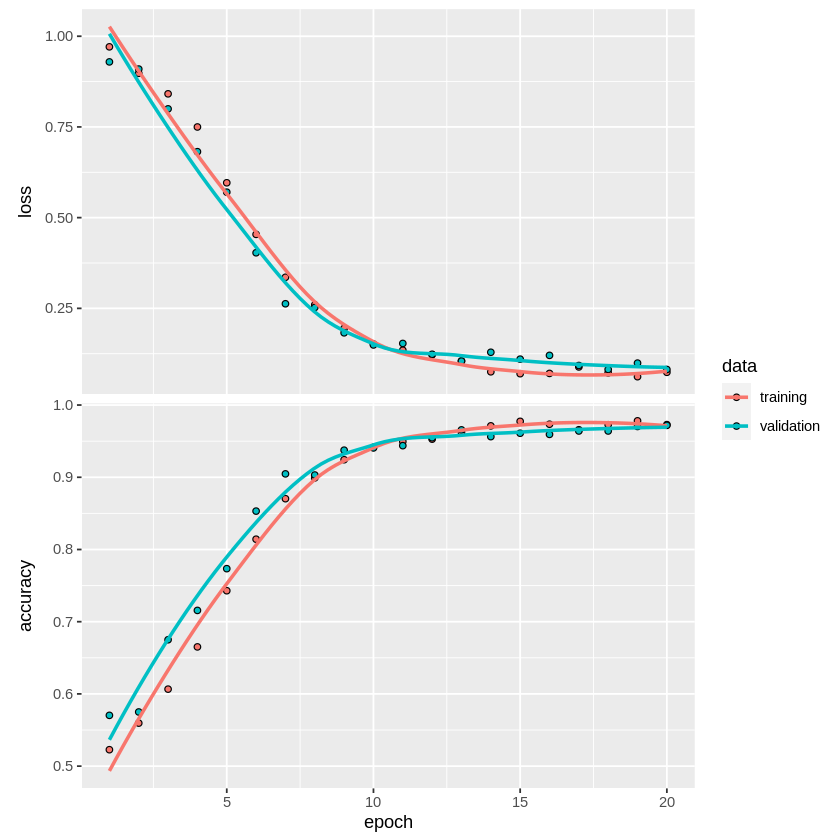

In [ ]:
 plot(history)

In [ ]:
loss <- evaluate(model, X_test, y_mat_test)[1]
accuracy <- evaluate(model, X_test, y_mat_test)[2]

predictions <- predict(model, X_test)
colnames(predictions) <- c("1", "2", "3", "4")
mcroc <- multiclass.roc(test$DX, predictions)$auc
predclasses <- as.vector(predict(model, X_test) %>% k_argmax()) + 1

test$DXunf <- unfactor(test$DX)
actltpred <- sum(test$DXunf < predclasses)/length(predclasses)
actgtpred <- sum(test$DXunf > predclasses)/length(predclasses)
nonacc <- sum(test$DXunf == 1 & predclasses == 1)/length(predclasses[predclasses == 1])
verymildacc <- sum(test$DXunf == 2 & predclasses == 2)/length(predclasses[predclasses == 2])
mildacc <- sum(test$DXunf == 3 & predclasses == 3)/length(predclasses[predclasses == 3])
modacc <- sum(test$DXunf == 4 & predclasses == 4)/length(predclasses[predclasses == 4])
dementiaacc <- sum(test$DXunf != 1 & predclasses != 1)/length(predclasses[predclasses != 1])

In [ ]:
loss
accuracy
mcroc
actltpred
actgtpred
nonacc
verymildacc
mildacc
modacc
dementiaacc

loss 
0.08152235

accuracy 
0.971875

Multi-class area under the curve: 0.9988

[1] 0.0125

[1] 0.015625

[1] 0.9770492

[1] 0.9570815

[1] 0.9892473

[1] 1

[1] 0.9791045

In [ ]:
head(predictions)

1,2,3,4
0.0000106793,9.999892e-01,1.299324e-10,1.145616e-09
0.9983456135,2.835097e-05,1.626045e-03,3.321264e-08
0.0930195153,9.068483e-01,1.310130e-04,1.198270e-06
0.9999998212,1.010958e-07,7.095424e-14,1.063805e-14
0.0058483277,9.940574e-01,3.429504e-05,5.994815e-05
0.9999881387,1.181562e-05,1.050995e-11,8.328036e-13


In [ ]:
head(y_mat)

0,1,0,0
0,1,0,0
0,1,0,0
0,1,0,0
0,1,0,0
0,1,0,0


In [ ]:
cross_entropy <- function(y_true, y_pred) {
  n <- nrow(y_true)
  K <- ncol(y_pred)
  x <- 0
  for (i in 1:n) {
    for (k in 1:K) {
      x <- x - y_true[i, k] * log(y_pred[i, k])
    }
  }
  x/n
}

In [ ]:
cross_entropy(y_mat_test, predictions)

1 
0.1055107